# TRITON — EFT & Bayesian Uncertainty Quantification

This notebook collects the numerical results produced by the TRITON code (three-body Faddeev solver) and performs a Bayesian uncertainty quantification (UQ) of EFT truncation errors order-by-order.

**Workflow**
1. Run TRITON (Fortran) to obtain binding energies at a chosen EFT order and regulator setup.
2. Define the EFT expansion parameter $ Q = p_{\mathrm{typ}}/\Lambda_b $.
3. Build a Bayesian predictive distribution for the observable at the given order.
4. Report credible intervals and produce plots.

**Observable**
- Triton binding energy $B$ (MeV).


## Theoretical background and references

The EFT truncation-error model and Bayesian uncertainty quantification implemented in this notebook are based on the following references:

- R. J. Furnstahl, N. Klco, D. R. Phillips, K. Wesolowski, *Quantifying truncation errors in effective    field theory*, Phys. Rev. C **92**, 024005 (2015).

- R. J. Furnstahl, D. R. Phillips, K. Wesolowski, *A recipe for EFT uncertainty quantification*, J. Phys. G **42**, 034028 (2015).

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

## Inputs (from TRITON and EFT conventions)

- $B_{\mathrm{LO}}$: computed by TRITON (Fortran output).
- $p_{\mathrm{typ}}$: typical momentum scale for the system (chosen/estimated).
- $\Lambda_b$: EFT breakdown scale (chosen/assumed).
- $Q = p_{\mathrm{typ}}/\Lambda_b$.

In [4]:
# --- TRITON output (LO) ---
B_LO = 11.746060  # MeV (from TRITON run)

# --- EFT scales used in the analysis ---
mN = 939.0 #MeV
p_typ = (B_LO*mN)**0.5  # MeV
Lambda_b = 600.0    # MeV

Q = p_typ / Lambda_b

print("B_LO =", B_LO, "MeV")
print("p_typ =", p_typ, "MeV")
print("Lambda_b =", Lambda_b, "MeV")
print("Q =", Q)

B_LO = 11.74606 MeV
p_typ = 105.02166605039172 MeV
Lambda_b = 600.0 MeV
Q = 0.1750361100839862


In [5]:
assert 0 < Q < 1, "Q should be between 0 and 1 for a convergent EFT expansion assumption."
print(f"Q = {Q:.6f}")

Q = 0.175036


## Bayesian truncation error model at LO (Gaussian)

At LO we model the unknown higher-order corrections as a random variable.

A minimal Gaussian model assumes: $B = B_{\mathrm{LO}} + \Delta_{\mathrm{trunc}}, \Delta_{\mathrm{trunc}} \sim \mathcal{N}(0,\sigma_{\mathrm{LO}}^2).$

A common EFT-motivated estimate is: $\sigma_{\mathrm{LO}} \equiv |B_{\mathrm{LO}}|\, Q, $
i.e. the next-order correction is expected to be of relative size \(Q\).

In [6]:
sigma_LO = abs(B_LO) * Q**2
print("sigma_LO =", sigma_LO, "MeV")

sigma_LO = 0.3598715557407234 MeV


In [7]:
# Gaussian central credible intervals:
# 68% ~ ±1 sigma
# 95% ~ ±1.96 sigma

CI68 = (B_LO - 1.0*sigma_LO,  B_LO + 1.0*sigma_LO)
CI95 = (B_LO - 1.96*sigma_LO, B_LO + 1.96*sigma_LO)

print(f"B_LO = {B_LO:.6f} MeV")
print(f"sigma_LO = {sigma_LO:.6f} MeV")
print(f"68% CI ~ [{CI68[0]:.6f}, {CI68[1]:.6f}] MeV")
print(f"95% CI ~ [{CI95[0]:.6f}, {CI95[1]:.6f}] MeV")

B_LO = 11.746060 MeV
sigma_LO = 0.359872 MeV
68% CI ~ [11.386188, 12.105932] MeV
95% CI ~ [11.040712, 12.451408] MeV


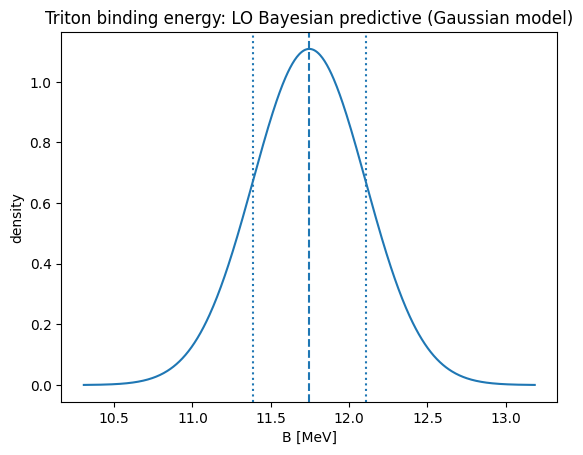

In [8]:
# plot a Gaussian predictive distribution
xs = np.linspace(max(0, B_LO - 4*sigma_LO), B_LO + 4*sigma_LO, 600)
pdf = (1/(sigma_LO*np.sqrt(2*np.pi))) * np.exp(-0.5*((xs - B_LO)/sigma_LO)**2)

plt.figure()
plt.plot(xs, pdf)
plt.axvline(B_LO, linestyle="--")
plt.axvline(CI68[0], linestyle=":")
plt.axvline(CI68[1], linestyle=":")
plt.title("Triton binding energy: LO Bayesian predictive (Gaussian model)")
plt.xlabel("B [MeV]")
plt.ylabel("density")
plt.show()

## Interpretation (LO)

- TRITON provides a deterministic LO prediction $B_{\mathrm{LO}}$.
- EFT tells us that missing higher-order contributions scale like powers of $Q$.
- The Bayesian model converts that expectation into a predictive distribution for the true value of $B$,
  yielding credible intervals (68%, 95%) interpreted as truncation uncertainty bands.

## Next steps (NLO, NNLO, ...)

When higher-order TRITON results become available:
- Add $B_{\mathrm{NLO}}, B_{\mathrm{NNLO}}, \dots$.
- Update the truncation model: $B = B_k + \sum_{n=k+1}^{\infty} c_n Q^n$
  with priors on the coefficients $c_n$.
- Infer posteriors for truncation error given the observed order-by-order pattern.

## NLO: extract $B_{NLO}$ from the run log and propagate EFT truncation error

At NLO in chiral EFT the nominal power counting for many observables is:
- LO: $\mathcal{O}(Q^0)$
- NLO: includes corrections up to $\mathcal{O}(Q^2)$
- the *first omitted* order after NLO is typically $\mathcal{O}(Q^3)$

So, if we keep the same $Q$ as defined above, a simple (transparent) truncation estimate is $\sigma_{\mathrm{NLO}} \approx |B_{\mathrm{NLO}}|\, Q^3 .$

> Note: if you adopt a different counting (or a different definition of $Q$ / breakdown scale), update the exponent accordingly and document it here.

In [9]:
B_NLO = 8.216502  #MeV (from TRITON)
print("B_NLO =", B_NLO, "MeV")

B_NLO = 8.216502 MeV


In [ ]:
# Q-choice:

# Option A: keep Q fixed from LO (recommended for clean order-to-order UQ comparison)
Q_ref = Q
print("Using fixed Q from LO:", Q_ref,)

# Option B: recompute Q at NLO from B_NLO (ONLY if you intentionally want order-dependent Q)
# mN = 939.0  # MeV 
# p_typ_NLO = math.sqrt(mN * abs(B_NLO))
# Q_NLO = p_typ_NLO / Lambda_b
# print("Order-dependent Q_NLO:", Q_NLO)


Using fixed Q from LO: 0.1750361100839862


In [14]:
#Simple NLO truncation estimate
sigma_NLO = abs(B_NLO) * (Q_ref**2)
print("sigma_NLO = ", sigma_NLO, "MeV")

sigma_NLO =  0.25173422896586306 MeV


In [ ]:
# Gaussian predictive model at NLO

mu_NLO = B_NLO

# 68% and 95% credible intervals for a Gaussian:
CI68_NLO = (mu_NLO - sigma_NLO, mu_NLO + sigma_NLO)
CI95_NLO = (mu_NLO - 1.96*sigma_NLO, mu_NLO + 1.96*sigma_NLO)

print("B_NLO =", mu_NLO, "MeV")
print("Q =", Q_ref)
print("sigma_NLO =", sigma_NLO, "MeV")
print("68% CI ~", CI68_NLO, "MeV")
print("95% CI ~", CI95_NLO, "MeV")

B_NLO = 8.216502 MeV
Q = 0.1750361100839862
sigma_NLO = 0.25173422896586306 MeV
68% CI ~ (7.964767771034137, 8.468236228965864) MeV
95% CI ~ (7.723102911226909, 8.709901088773092) MeV


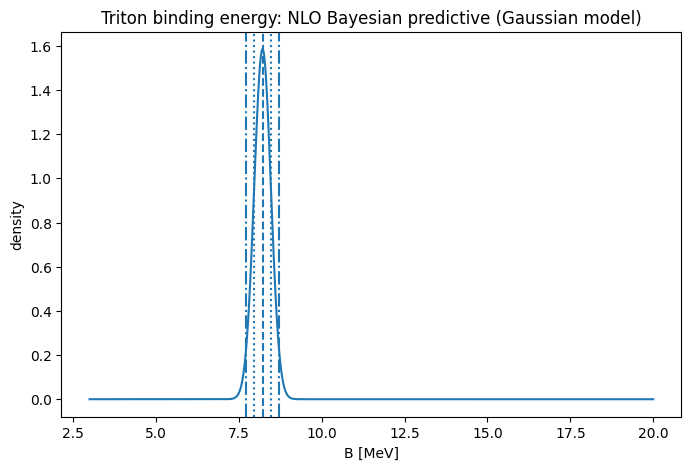

In [ ]:
def gaussian_pdf(x, mu, sigma):
    return (1.0/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu)/sigma)**2)

# Plot range 
B_grid = np.linspace(3.0, 20.0, 2000)

pdf_NLO = gaussian_pdf(B_grid, mu_NLO, sigma_NLO)

plt.figure(figsize=(8,5))
plt.plot(B_grid, pdf_NLO)
plt.title("Triton binding energy: NLO Bayesian predictive (Gaussian model)")
plt.xlabel("B [MeV]")
plt.ylabel("density")

# Vertical markers: mean, 68%, 95%
plt.axvline(mu_NLO, linestyle="--")
plt.axvline(CI68_NLO[0], linestyle=":")
plt.axvline(CI68_NLO[1], linestyle=":")
plt.axvline(CI95_NLO[0], linestyle="-.")
plt.axvline(CI95_NLO[1], linestyle="-.")

plt.show()


### LO vs NLO

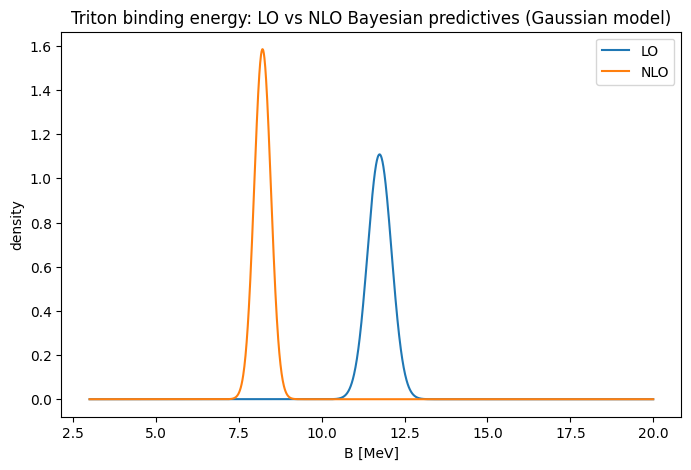

In [17]:
# Compare LO vs NLO predictives
pdf_LO  = gaussian_pdf(B_grid, B_LO,  sigma_LO)
pdf_NLO = gaussian_pdf(B_grid, B_NLO, sigma_NLO)

plt.figure(figsize=(8,5))
plt.plot(B_grid, pdf_LO, label="LO")
plt.plot(B_grid, pdf_NLO, label="NLO")
plt.title("Triton binding energy: LO vs NLO Bayesian predictives (Gaussian model)")
plt.xlabel("B [MeV]")
plt.ylabel("density")
plt.legend()
plt.show()

## N2LO


In [19]:
# === N2LO result from TRITON ===
B_N2LO = 8.142990 # MeV 
print("B_N2LO =", B_N2LO, "MeV")

B_N2LO = 8.14299 MeV


In [21]:
# === Simple N2LO truncation estimate ===
sigma_N2LO = abs(B_N2LO) * (Q_ref**3)
print("sigma_N2LO =", sigma_N2LO, "MeV")

sigma_N2LO = 0.043668357903410907 MeV


In [22]:
# === N2LO Gaussian predictive ===
mu_N2LO = B_N2LO
sig_N2LO = sigma_N2LO

CI68_N2LO = (mu_N2LO - sig_N2LO, mu_N2LO + sig_N2LO)
CI95_N2LO = (mu_N2LO - 1.96*sig_N2LO, mu_N2LO + 1.96*sig_N2LO)

print("N2LO:")
print("  mu =", mu_N2LO, "MeV")
print("  sigma =", sig_N2LO, "MeV")
print("  68% CI ~", CI68_N2LO, "MeV")
print("  95% CI ~", CI95_N2LO, "MeV")

N2LO:
  mu = 8.14299 MeV
  sigma = 0.043668357903410907 MeV
  68% CI ~ (8.099321642096589, 8.18665835790341) MeV
  95% CI ~ (8.057400018509314, 8.228579981490684) MeV


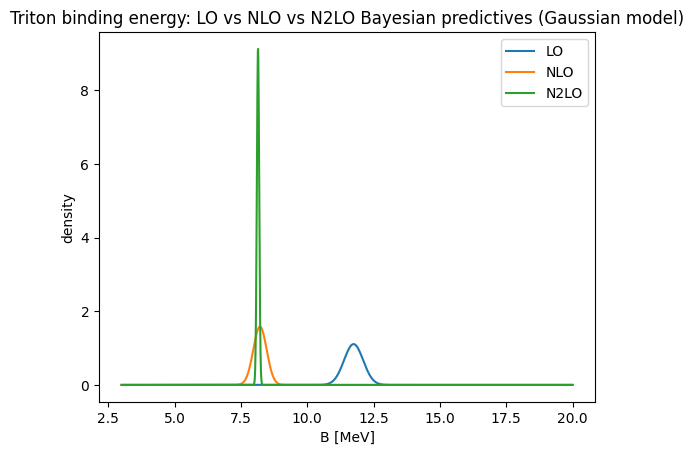

In [23]:
def gaussian_pdf(x, mu, sig):
    return (1.0/(sig*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu)/sig)**2)

pdf_LO  = gaussian_pdf(B_grid, B_LO,  sigma_LO)
pdf_NLO = gaussian_pdf(B_grid, B_NLO, sigma_NLO)
pdf_N2LO = gaussian_pdf(B_grid, B_N2LO, sigma_N2LO)

plt.figure()
plt.plot(B_grid, pdf_LO, label="LO")
plt.plot(B_grid, pdf_NLO, label="NLO")
plt.plot(B_grid, pdf_N2LO, label="N2LO")
plt.xlabel("B [MeV]")
plt.ylabel("density")
plt.title("Triton binding energy: LO vs NLO vs N2LO Bayesian predictives (Gaussian model)")
plt.legend()
plt.show()

In [24]:
import pandas as pd

summary = pd.DataFrame({
    "order": ["LO", "NLO", "N2LO"],
    "B [MeV]": [B_LO, B_NLO, B_N2LO],
    "sigma [MeV]": [sigma_LO, sigma_NLO, sigma_N2LO],
    "68% low": [B_LO - sigma_LO, B_NLO - sigma_NLO, B_N2LO - sigma_N2LO],
    "68% high":[B_LO + sigma_LO, B_NLO + sigma_NLO, B_N2LO + sigma_N2LO],
})
summary

,order,B [MeV],sigma [MeV],68% low,68% high
0,LO,11.746060,0.359872,11.386188,12.105932
1,NLO,8.216502,0.251734,7.964768,8.468236
2,N2LO,8.142990,0.043668,8.099322,8.186658
